## 0. load all necessary packages

In [1]:
from __future__ import print_function
import numpy as np
import pandas as pd
import pylab as pl
import os
import geopandas as gpd
from geopandas import GeoDataFrame
%pylab inline


Populating the interactive namespace from numpy and matplotlib


In [12]:
from fiona.crs import from_epsg
import shapely
from shapely.geometry import Point

In [15]:
import seaborn
from descartes import PolygonPatch

/opt/rh/anaconda/root/envs/PUI2016_Python2/lib/python2.7/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


## 1. download data

In [4]:
def download_nycb2010_16d_zip():
    os.system("curl -O http://www1.nyc.gov/assets/planning/download/zip/data-maps/open-data/nycb2010_16d.zip") 
    os.system("mv " + "nycb2010_16d.zip " + os.getenv("PUIDATA")+"/nycb2010_16d.zip")
    os.system("unzip " + os.getenv("PUIDATA")  + "/nycb2010_16d.zip -d " + os.getenv("PUIDATA"))
    os.system("rm " + os.getenv("PUIDATA") + "/nycb2010_16d.zip")

In [5]:
download_nycb2010_16d_zip()

In [6]:
shape_path = os.getenv("PUIDATA") + '/nycb2010_16d/nycb2010.shp'

In [7]:
ct_shape = GeoDataFrame.from_file(shape_path)

In [8]:
ct_shape.head()

,BCTCB2010,BoroCode,BoroName,CB2010,CT2010,Shape_Area,Shape_Leng,geometry
0,50009001000,5,Staten Island,1000,000900,244589.603884,2508.948115,"POLYGON ((962269.1260375977 173705.5001831055,..."
1,50020011000,5,Staten Island,1000,002001,111006.286826,1345.886422,"POLYGON ((964642.2676391602 161835.2651977539,..."
2,50027001000,5,Staten Island,1000,002700,150406.766022,1703.381172,"POLYGON ((963363.1168212891 167356.3336181641,..."
3,50040001000,5,Staten Island,1000,004000,141296.561149,1511.173743,"POLYGON ((960069.9965820312 161953.6936035156,..."
4,50064001000,5,Staten Island,1000,006400,200784.983607,1978.243852,"POLYGON ((963023.891784668 158246.7521972656, ..."


## 2. Extract only the Brooklyn shape polygons and convert the coordinates to lat/lon

In [9]:
ct_latlon = ct_shape[ct_shape.BoroName == 'Brooklyn']
ct_latlon.head()

,BCTCB2010,BoroCode,BoroName,CB2010,CT2010,Shape_Area,Shape_Leng,geometry
5037,30002001000,3,Brooklyn,1000,000200,208484.989566,2097.493132,"POLYGON ((982421.0634155273 178133.8510131836,..."
5038,30003011000,3,Brooklyn,1000,000301,63365.958361,1006.913933,"POLYGON ((985596.1882324219 193858.6517944336,..."
5039,30005011000,3,Brooklyn,1000,000501,116303.194723,1431.900698,"POLYGON ((986271.9053955078 193612.9270019531,..."
5040,30011001000,3,Brooklyn,1000,001100,54802.306859,951.657541,"POLYGON ((988369.8604125977 192442.1943969727,..."
5041,30015001000,3,Brooklyn,1000,001500,79196.530872,1129.348482,"POLYGON ((988949.616394043 193714.8265991211, ..."


In [10]:
ct_latlon = ct_latlon.to_crs(epsg=4326)

In [11]:
ct_latlon.head()

,BCTCB2010,BoroCode,BoroName,CB2010,CT2010,Shape_Area,Shape_Leng,geometry
5037,30002001000,3,Brooklyn,1000,000200,208484.989566,2097.493132,"POLYGON ((-74.00659158337982 40.6556127336851,..."
5038,30003011000,3,Brooklyn,1000,000301,63365.958361,1006.913933,POLYGON ((-73.99514512602698 40.69877384570529...
5039,30005011000,3,Brooklyn,1000,000501,116303.194723,1431.900698,"POLYGON ((-73.99270830309769 40.6980992598468,..."
5040,30011001000,3,Brooklyn,1000,001100,54802.306859,951.657541,"POLYGON ((-73.9851430608965 40.69488514300315,..."
5041,30015001000,3,Brooklyn,1000,001500,79196.530872,1129.348482,POLYGON ((-73.98305147125492 40.69837793357372...


## 3. Find the coordinates of CUSP: 1 MetroTech Brooklyn. Create a Point shapely geometry with the coordinates of CUSP

In [13]:
cusp_coor = [-73.9866, 40.6931]
cusp_shapely_geometry = Point(cusp_coor)

## 4. Loop over the Brookly polygons (nearly 10000) and assess find in which geometry the polygon is contained

In [14]:
for i in ct_latlon.index:
    if shapely.geometry.asShape(ct_latlon.geometry[i]).contains(cusp_shapely_geometry):
        index = i
        ct = ct_latlon.geometry[i]
        print('CUSP is contained in', ct)

CUSP is contained in POLYGON ((-73.98622595691906 40.69308831343839, -73.98627231669103 40.6921947946671, -73.98729894947923 40.69223407543156, -73.98725396415627 40.69312490276504, -73.98622595691906 40.69308831343839))


## 5. Plot one every 10 polygons of brooklyn (using the geopandas datafame method plot) and overplot the location of cusp as a point (using pylab.scatter) Overplot also the census track that contains cusp in red (using the geopandas datafame method plot)

In [16]:
ct_latlon_10 = ct_latlon.iloc[::10]
ct_latlon_10.head()

,BCTCB2010,BoroCode,BoroName,CB2010,CT2010,Shape_Area,Shape_Leng,geometry
5037,30002001000,3,Brooklyn,1000,000200,208484.989566,2097.493132,"POLYGON ((-74.00659158337982 40.6556127336851,..."
5047,30035001000,3,Brooklyn,1000,003500,10469.636350,507.804498,POLYGON ((-73.97551988364874 40.68675683612325...
5057,30054001000,3,Brooklyn,1000,005400,189033.189700,1938.321547,POLYGON ((-74.03649125984289 40.61798915520121...
5067,30067001000,3,Brooklyn,1000,006700,198454.446949,1936.158155,POLYGON ((-73.99440802432692 40.68545249602955...
5077,30084001000,3,Brooklyn,1000,008400,208451.540053,2121.627337,POLYGON ((-74.00041318188852 40.65462870194952...


(40.56, 40.74)

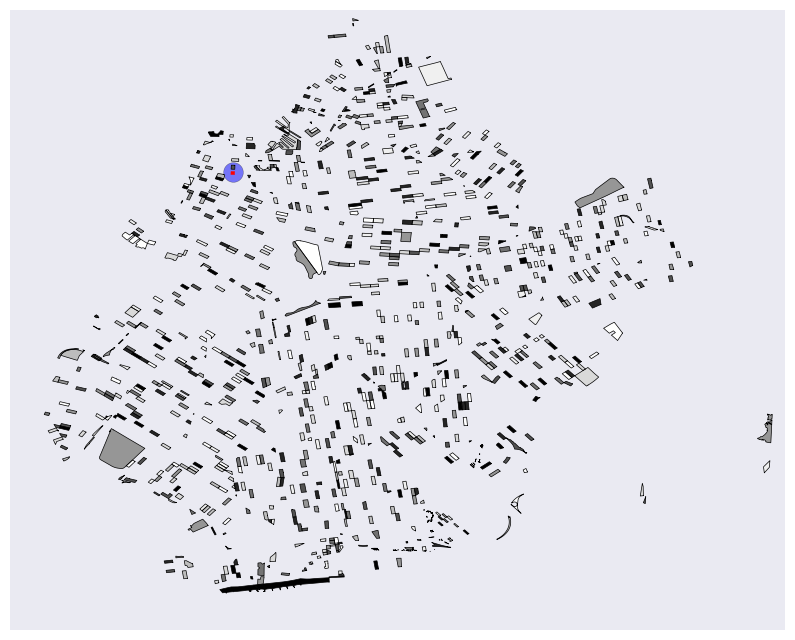

In [17]:
fig, ax = pl.subplots(figsize=(10,8))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ct_latlon_10.geometry.plot(cmap='Greys', alpha=1, linewidth=0.5, ax=ax)
ax.scatter(cusp_shapely_geometry.x, cusp_shapely_geometry.y, c='blue', alpha=0.5, s=200)
ct_patch = PolygonPatch(ct, fc='red', ec='red', alpha=1)
ax.add_patch(ct_patch)
ax.set_xlim(-74.05, -73.83)
ax.set_ylim(40.56, 40.74)

### Figure 1: Brooklyn Polygons with CUSP in Blue at the Census Tract Polygon in Red